In [20]:
import pandas as pd
import numpy as np
train_no= 22222
brdpt= "NZM" # Write -1 here to predict overall demand
resupto="CSMT"
cls="3A"
df=pd.read_csv(f"../CRIS_data/train_demand/demand_{train_no}.csv")



In [21]:
# Basic cleaning
df.columns = df.columns.str.strip().str.strip("'")
df.columns = df.columns.str.strip()
cols_to_clean = ['brdpt_code', 'resupto_code', 'cls', 'trnno']
for col in cols_to_clean:
    df[col] = df[col].str.strip().str.strip("'")
    df[col] = df[col].str.strip()
df.columns = df.columns.str.strip()

# format of dates
df['booking_date'] = pd.to_datetime(df['booking_date'])
df['journey_date'] = pd.to_datetime(df['journey_date'])




In [22]:


if (brdpt==-1):
    
    df= df[
        df['cls']==cls
    ].copy()
else:

    df=df[
        (df['cls']==cls) &
        (df['brdpt_code']==brdpt) &
        (df['resupto_code']==resupto)
    ].copy()
df['days_to_departure'] = (df['journey_date'] - df['booking_date']).dt.days
df1=df.copy()
# passengers booked with days_to_departure >= 30 (feature)
df['psgn_advanced'] = np.where(df['days_to_departure'] > 30, df['PSGN'], 0)

# 2. Group by 'journey_date' and aggregate both columns
df = df.groupby('journey_date').agg(
    total_psgn=('PSGN', 'sum'),
    psgn_over_30_days=('psgn_advanced', 'sum')
).reset_index()

print(df)

    journey_date  total_psgn  psgn_over_30_days
0     2023-08-01          54                  1
1     2023-08-02          90                  7
2     2023-08-03          79                  6
3     2023-08-04          80                  4
4     2023-08-05         154                 14
..           ...         ...                ...
726   2025-07-27         192                 11
727   2025-07-28         197                  7
728   2025-07-29         203                  8
729   2025-07-30         162                 10
730   2025-07-31         127                  4

[731 rows x 3 columns]


In [23]:
from datetime import timedelta
if ('PSGN' in df.columns):
    df.rename(columns={'PSGN': 'total_psgn'}, inplace=True)

# ---- Holiday dictionary ----
holidays = {
    # 2023
    "26-01-2023": "Republic Day",
    "15-08-2023": "Independence Day",
    "02-10-2023": "Gandhi Jayanti",
    "25-12-2023": "Christmas",
    "12-11-2023": "Diwali",
    "07-03-2023": "Holi",
    "05-09-2023": "Eid",

    # 2024
    "26-01-2024": "Republic Day",
    "15-08-2024": "Independence Day",
    "02-10-2024": "Gandhi Jayanti",
    "25-12-2024": "Christmas",
    "31-10-2024": "Diwali",
    "15-08-2024": "Raksha Bandhan",
    "26-08-2024": "Janmashtami",
    "25-03-2024": "Holi",

    # 2025
    "26-01-2025": "Republic Day",
    "15-08-2025": "Independence Day",
    "02-10-2025": "Gandhi Jayanti",
    "25-12-2025": "Christmas",
    "20-10-2025": "Diwali",
    "31-03-2025": "Holi",
    "05-09-2025": "Eid",
}

holiday_dates = pd.to_datetime(list(holidays.keys()), format='%d-%m-%Y').date


# --- 2. Add Weekday Binary Columns ---
print("Adding weekday binary columns...")
df['is_sunday'] = (df['journey_date'].dt.day_name() == 'Sunday').astype(int)
df['is_saturday'] = (df['journey_date'].dt.day_name() == 'Saturday').astype(int)
df['is_friday'] = (df['journey_date'].dt.day_name()== 'Friday').astype(int)
df['is_rest_day'] = (~df['journey_date'].dt.day_name().isin(['Sunday', 'Saturday', 'Friday'])).astype(int)


# --- 3. Add Seasonal Binary Columns ---
print("Adding seasonal binary columns...")
# Binary column for peak summer season (15th May to 15th June)
df['is_peak_season'] = (
    (df['journey_date'].dt.month == 5) & (df['journey_date'].dt.day >= 15) |
    (df['journey_date'].dt.month == 6) & (df['journey_date'].dt.day <= 15)
).astype(int)

# Binary column for winter months (December and January)
df['is_winter_season'] = df['journey_date'].dt.month.isin([12, 1]).astype(int)


# --- 4. Add Holiday Period Column ---
print("Adding holiday period column...")

# Create sets for near-holidays and long weekends
near_holiday_dates = set()
long_weekend_dates = set()

for holiday in holiday_dates:
    # Add the day before and after the holiday
    # near_holiday_dates.add(holiday - timedelta(days=1))
    # near_holiday_dates.add(holiday + timedelta(days=1))
    
    # Check for long weekends (holiday on Monday or Friday)
    if holiday.weekday() == 0:  # Monday
        long_weekend_dates.update([holiday, holiday - timedelta(days=1), holiday - timedelta(days=2), holiday - timedelta(days=3)])
    elif holiday.weekday() == 4:  # Friday
        long_weekend_dates.update([holiday, holiday + timedelta(days=1), holiday + timedelta(days=2), holiday + timedelta(days=3)])

# Combine all special dates into one large set
holiday_period_dates = set(holiday_dates) | near_holiday_dates | long_weekend_dates

# Create the final binary column by checking if the journey date is in the combined set
df['is_holiday_period'] = df['journey_date'].apply(lambda x: x.date() in holiday_period_dates).astype(int)


# Adding sine and cosines
df['m'] = df['journey_date'].dt.month
df['d'] = df['journey_date'].dt.day
# Create cyclical month features
df['month_sin'] = np.sin(2 * np.pi * (30*df['m']+df['d']) /360)
df['month_cos'] = np.cos(2 * np.pi * (30*df['m']+df['d']) /360)

# Create cyclical day features
# df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
# df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)


# adding diwali and holi
diwali_dates = []
holi_dates = []

for date_str, name in holidays.items():
    dt_obj = pd.to_datetime(date_str, format='%d-%m-%Y').date()
    if name == "Diwali":
        diwali_dates.append(dt_obj)
    elif name == "Holi":
        holi_dates.append(dt_obj)

# --- Alternative Method: Capturing the Calendar Week ---

# Sets to hold all dates within the festival's calendar week
diwali_calendar_weeks = set()
holi_calendar_weeks = set()

# For Diwali
for date in diwali_dates:
    # .weekday() is 0 for Monday, 6 for Sunday.
    # To find the preceding Sunday, we go back (date.weekday() + 1) % 7 days.
    start_of_week = date - timedelta(days=(date.weekday() + 1) % 7)
    for i in range(7): # Add all 7 days of that week
        diwali_calendar_weeks.add(start_of_week + timedelta(days=i))

# For Holi (same logic)
for date in holi_dates:
    start_of_week = date - timedelta(days=(date.weekday() + 1) % 7)
    for i in range(7):
        holi_calendar_weeks.add(start_of_week + timedelta(days=i))

# Create the columns using this new logic
df['is_diwali'] = df['journey_date'].apply(
    lambda x: x.date() in diwali_calendar_weeks
).astype(int)

df['is_holi']= df['journey_date'].apply(
    lambda x: x.date() in holi_calendar_weeks
).astype(int)


# --- 5. Display Result ---
print("\nDataFrame with new feature columns:")
print(df)


Adding weekday binary columns...
Adding seasonal binary columns...
Adding holiday period column...

DataFrame with new feature columns:
    journey_date  total_psgn  psgn_over_30_days  is_sunday  is_saturday  \
0     2023-08-01          54                  1          0            0   
1     2023-08-02          90                  7          0            0   
2     2023-08-03          79                  6          0            0   
3     2023-08-04          80                  4          0            0   
4     2023-08-05         154                 14          0            1   
..           ...         ...                ...        ...          ...   
726   2025-07-27         192                 11          1            0   
727   2025-07-28         197                  7          0            0   
728   2025-07-29         203                  8          0            0   
729   2025-07-30         162                 10          0            0   
730   2025-07-31         127           

In [24]:
features = [
    'is_sunday', 
    'is_saturday', 
    'is_friday', 
    'is_peak_season', 
    'is_winter_season', 
    'is_holiday_period',
    'month_sin',
    'month_cos',
    'is_diwali',
    'is_holi',
    'psgn_over_30_days'
    
]
df = df.set_index('journey_date').sort_index()

X = df[features]
y = df['total_psgn']

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y, exog=X, order=(4,1,0), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())


c:\Users\mailt\OneDrive\Desktop\dpOnTrain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mailt\OneDrive\Desktop\dpOnTrain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mailt\OneDrive\Desktop\dpOnTrain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                          total_psgn   No. Observations:                  731
Model:             SARIMAX(4, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -3609.858
Date:                             Tue, 23 Sep 2025   AIC                           7255.716
Time:                                     11:25:59   BIC                           7337.942
Sample:                                 08-01-2023   HQIC                          7287.476
                                      - 07-31-2025                                         
Covariance Type:                               opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_sunday             0.0365   4185.307   8.73e-06      1.000   -8203.015    8203.088
is_sat

R² Score: 0.5646650961921071


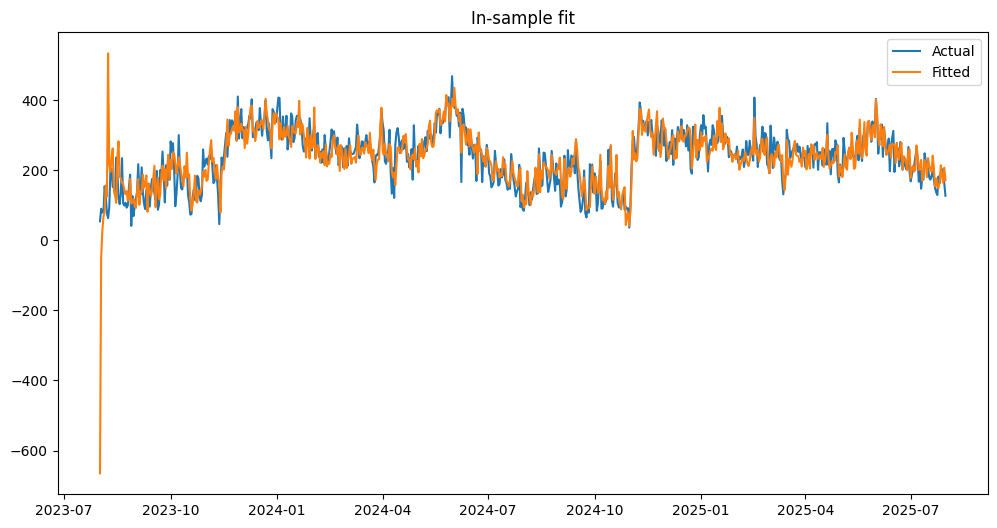

In [26]:
df['fitted'] = res.fittedvalues
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score

# Actual vs fitted
r2 = r2_score(y, df['fitted'])
print("R² Score:", r2)

plt.figure(figsize=(12, 6))
plt.plot( y, label='Actual')
plt.plot(df['fitted'], label='Fitted')
plt.legend()
plt.title("In-sample fit")
plt.show()

In [27]:
# n days before departure (d)
# data available- bookings for that train from 60 to n+1 days before departure
# for train leaving on (d-x) day, bookings for that train from 60 to n+1+x days before departure

In [ ]:
# plot psgn vs  days to departure 

,booking_date,journey_date,trnno,brdpt_code,resupto_code,cls,PSGN,days_to_departure
18,2023-06-08,2023-08-01,22222,NZM,CSMT,3A,1,54
65,2023-07-08,2023-08-01,22222,NZM,CSMT,3A,3,24
78,2023-07-11,2023-08-01,22222,NZM,CSMT,3A,1,21
84,2023-07-13,2023-08-01,22222,NZM,CSMT,3A,3,19
90,2023-07-14,2023-08-01,22222,NZM,CSMT,3A,3,18
...,...,...,...,...,...,...,...,...
384365,2025-07-27,2025-07-31,22222,NZM,CSMT,3A,5,4
384381,2025-07-28,2025-07-31,22222,NZM,CSMT,3A,9,3
384402,2025-07-29,2025-07-31,22222,NZM,CSMT,3A,17,2
384434,2025-07-30,2025-07-31,22222,NZM,CSMT,3A,28,1
